In [145]:
import sqlite3
import pandas as pd
import numpy as np
import plotly.express as px

In [146]:
### --- HELPER FUNCTIONS --- ###
def dbquery_find_list(search_list: list,
                      db_column: str,
                      db_table: str,
                      db_file: str) -> pd.DataFrame:
    query = f"SELECT * FROM {db_table} WHERE {db_column} IN ({','.join(['?']*len(search_list))}) ORDER BY {db_column} ASC"
    conn = sqlite3.connect(db_file)
    df = pd.read_sql(query, conn, params=search_list)
    conn.close()
    return df

In [152]:
### --- ALLOCATE DATA --- ###
db_file = '../data/mpibr_synprot.db'
query_list = ['Dlg4','Gad1', 'Gad2', 
               'Shank1', 'Slc17a7', 'Slc32a', 
               'Slc6a3', 'Th', 'Camk2a']
df_info = dbquery_find_list(query_list, 'gene', 'info', db_file)
df_enriched = dbquery_find_list(df_info['protein'].to_list(), 'protein', 'enriched', db_file)
df_expressed = dbquery_find_list(df_info['protein'].to_list(), 'protein', 'expressed', db_file)

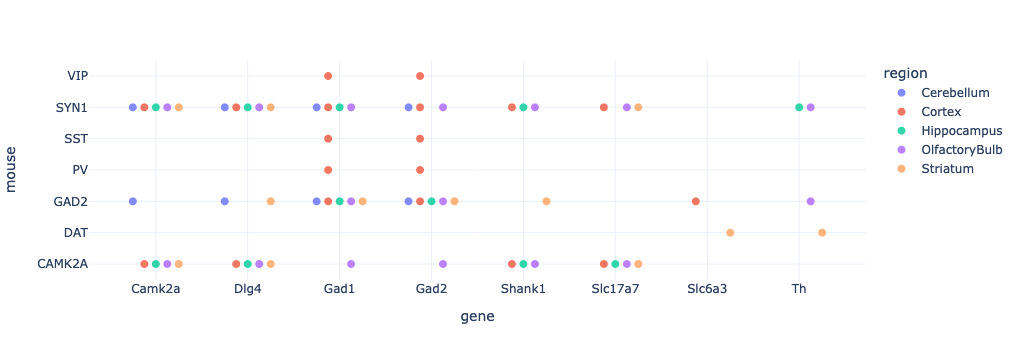

In [187]:
### --- PLOT ENRICHMENT --- ###
df = df_enriched.set_index('protein')

list_brain = []
list_mouse = []
for key in df.columns:
    brain, mouse = str.split(key, sep='.')
    list_brain.append(brain)
    list_mouse.append(mouse)
list_unq_brain = sorted(set(list_brain))
list_unq_mouse = sorted(set(list_mouse))

value_x_step = 0.125
value_x_min = -0.25

label_x = []
label_y = list_unq_mouse
label_gene = []
label_region = []
value_x = []
value_y = []
for value_x_tick, row_info in df_info.iterrows():
    label_x.append(row_info['gene'])
    row_enriched = df.loc[row_info['protein']]
    for key, value in row_enriched.items():
        if value == 1:
            brain, mouse = str.split(key, sep='.')
            value_x_shift = list_unq_brain.index(brain)
            value_x_point = (value_x_tick + 1) + (value_x_min + value_x_step * value_x_shift)
            value_x.append(value_x_point)
            value_y.append(list_unq_mouse.index(mouse) + 1)
            label_region.append(brain)
            label_gene.append(row_info['gene'])

df = pd.DataFrame({'x': value_x, 'mouse': value_y, 'region': label_region, 'gene': label_gene})

label_y[label_y.index('Camk2a')] = 'CAMK2A'
label_y[label_y.index('Syn1')] = 'SYN1'
label_y[label_y.index('Gad2')] = 'GAD2'
label_y[label_y.index('Dat1')] = 'DAT'



fig = px.scatter(df, x='x', y='mouse', color='region', opacity=0.8,
                 category_orders={'region': list_unq_brain},
                 template='plotly_white',
                 hover_name = 'gene',
                 hover_data={'region':True,'x':False,'mouse':True})
fig.update_traces(marker=dict(size=8))
fig.update_layout(xaxis=dict(tickmode="array", tickvals=np.arange(0, len(label_x)) + 1,
                              ticktext=label_x),
                  yaxis=dict(tickmode="array", tickvals=np.arange(0, len(label_y)) + 1,
                              ticktext=label_y),
                 xaxis_title='gene',
                 yaxis_title='mouse',
                 )

fig.show()